In [2]:
import sqlite3

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab

import itertools


In [5]:
#!pip install kaggle
import os
import os.path

# TODO: get json file read in

os.environ['KAGGLE_USERNAME']="andrewmokhta"
os.environ['KAGGLE_KEY']="eb7de261bcf48ef0ca684c07e28bb309"

from kaggle.api.kaggle_api_extended import KaggleApi

In [6]:
#!mkdir ../kaggle_test
# !pip install kaggle

In [7]:

if os.path.exists("../data/raw/database.sqlite"):
    print("Raw data already downloaded from Kaggle! Moving on to next step")
else:
    print("Does not exist, downloading")
    # kapi = KaggleApi()
    # kapi.authenticate()

    # print(kapi.dataset_list_files('benhamner/nips-papers').files)
    # kapi.dataset_download_files('benhamner/nips-papers', path='data/raw/', quiet=False, unzip=True)

Does not exist, downloading


# DATASETS (Properly creating/displaying networks)

In [8]:
def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(50, 50), dpi=100)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph, seed=22)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos, alpha=0.5)
    nx.draw_networkx_labels(graph,pos)
    
    plt.savefig(file_name,bbox_inches="tight")
    pylab.close()
    del fig

In [9]:
def read_edge(gph, n0, n1): #add switch between plus and multiply
    if gph.has_edge(n0, n1):
        gph[n0][n1]['weight'] +=1 #*= 2
        return gph[n0][n1]['weight']
    else:
        gph.add_edge(n0, n1, weight=1)
        return 1

## NIPS

In [10]:
#https://www.kaggle.com/code/kevinvdsk/community-detection


connect = sqlite3.connect('../data/NIPS/database.sqlite')
query = """
SELECT pa.paper_id, pa.author_id, a.name AS author_name
FROM paper_authors AS pa JOIN papers AS p ON pa.paper_id = p.id
JOIN authors as a ON pa.author_id = a.id
WHERE p.Year BETWEEN '2015' AND '2018'
ORDER BY paper_id
"""
df_nips = pd.read_sql(query, connect)

# Have a look at data
df_nips.head(10)

,paper_id,author_id,author_name
0,5633,7865,Leon Gatys
1,5633,7866,Alexander S. Ecker
2,5633,2385,Matthias Bethge
3,5634,7867,Ming Liang
4,5634,7868,Xiaolin Hu
5,5634,3841,Bo Zhang
6,5635,5571,Oriol Vinyals
7,5635,7869,?ukasz Kaiser
8,5635,7870,Terry Koo
9,5635,3753,Slav Petrov


In [11]:
len(df_nips['author_id'].unique())

3670

In [12]:
G = nx.Graph()

for p, a in df_nips.groupby('paper_id')['author_name']: 
    # TESTING print(a)
    for a1, a2 in itertools.combinations(a, 2):
        # creates an edge
        read_edge(G, a1, a2)
        

In [13]:
len(G), G.size()

(3637, 8180)

In [14]:
# save_graph(G_NIPS, "../data/NIPS/graph3.pdf")

## Degree Counting

<BarContainer object of 46 artists>

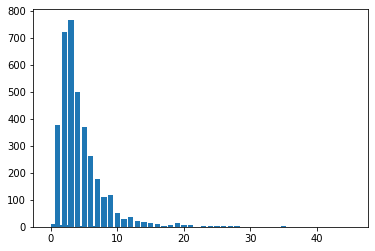

In [15]:
z = nx.degree_histogram(G)
plt.hist(z, bins=range(len(z)))
plt.bar(range(len(z)), z)

In [16]:
deg = [i[1] for i in G.degree]
(max(deg)), sum(deg)/len(deg)

(45, 4.498212812757767)

In [17]:
deg = [(i[1], i[0]) for i in G.degree]
deg.sort()

In [18]:
# top 10 degree count nodes
deg_nodes = deg[::-1][:10]
deg_nodes

[(45, 'Nicolas Heess'),
 (42, 'Lawrence Carin'),
 (37, 'Ruslan R. Salakhutdinov'),
 (36, 'Oriol Vinyals'),
 (35, 'Yoshua Bengio'),
 (35, 'Razvan Pascanu'),
 (35, 'Pieter Abbeel'),
 (35, 'David Silver'),
 (34, 'Michael I. Jordan'),
 (32, 'Le Song')]

In [19]:
# all nodes connected to the one with the most connections
node_big = deg_nodes[0][1]
clique_nodes = [n for n in G.neighbors(node_big)]
clique_nodes.append(node_big)
clique_nodes

['Gregory Wayne',
 'David Silver',
 'Tim Lillicrap',
 'Tom Erez',
 'Yuval Tassa',
 'John Schulman',
 'Theophane Weber',
 'Pieter Abbeel',
 'S. M. Ali Eslami',
 'David Szepesvari',
 'koray kavukcuoglu',
 'Geoffrey E. Hinton',
 'Danilo Jimenez Rezende',
 'Shakir Mohamed',
 'Peter Battaglia',
 'Max Jaderberg',
 'Yee Teh',
 'Victor Bapst',
 'Wojciech M. Czarnecki',
 'John Quan',
 'James Kirkpatrick',
 'Raia Hadsell',
 'Razvan Pascanu',
 'Ziyu Wang',
 'Josh S. Merel',
 'Scott E. Reed',
 'Nando de Freitas',
 'S?bastien Racani?re',
 'David Reichert',
 'Lars Buesing',
 'Arthur Guez',
 'Adri? Puigdom?nech Badia',
 'Oriol Vinyals',
 'Yujia Li',
 'Demis Hassabis',
 'Daan Wierstra',
 'Chris J. Maddison',
 'John Lawson',
 'George Tucker',
 'Mohammad Norouzi',
 'Andriy Mnih',
 'Arnaud Doucet',
 'Danijar Hafner',
 'Alexander Irpan',
 'James Davidson',
 'Nicolas Heess']

In [20]:
clique_nodes_deg = []
for i in deg:
    if i[1] in clique_nodes:
        clique_nodes_deg.append(i)


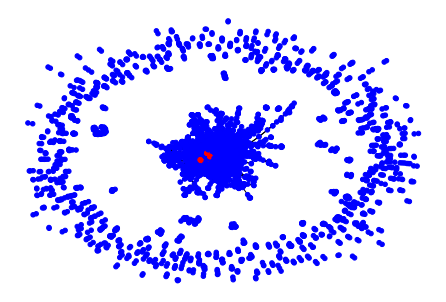

In [21]:
pred_clique_color = ['r' if node in clique_nodes else 'b' for node in G]
nx.draw(G, node_color = pred_clique_color, node_size=20)

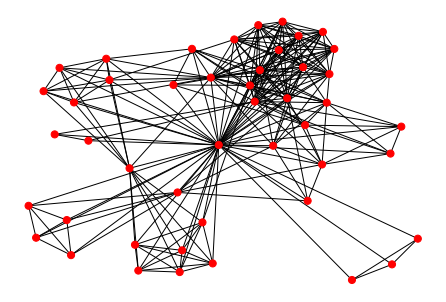

In [22]:
G_big = nx.Graph()

for p, a in df_nips.groupby('paper_id')['author_name']: 
    # TESTING print(a)
    for a1, a2 in itertools.combinations(a, 2):
        if (a1 in clique_nodes) and (a2 in clique_nodes):
            # creates an edge
            read_edge(G_big, a1, a2)

# nodes connected to highest degree node, but also include edges between these nodes too (if they exist)
pred_clique_color = ['r' if node in clique_nodes else 'b' for node in G_big]
nx.draw(G_big, node_color = pred_clique_color, node_size=50)


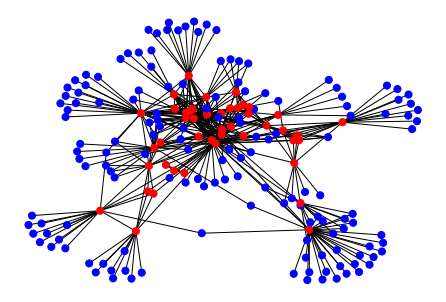

In [23]:
G_big = nx.Graph()

for p, a in df_nips.groupby('paper_id')['author_name']: 
    # TESTING print(a)
    for a1, a2 in itertools.combinations(a, 2):
        if (a1 in clique_nodes) or (a2 in clique_nodes):
            # creates an edge
            read_edge(G_big, a1, a2)

# nodes connected to highest degree node, but also include edges between these nodes too (if they exist)
pred_clique_color = ['r' if node in clique_nodes else 'b' for node in G_big]
nx.draw(G_big, node_color = pred_clique_color, node_size=50)


## Spectral Clustering

1. Find adjacency matrix to construct the graph Laplacian

2. Get top eigenvectors

In [17]:
a = nx.to_numpy_matrix(G)
a

matrix([[0., 1., 1., ..., 0., 0., 0.],
        [1., 0., 2., ..., 0., 0., 0.],
        [1., 2., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [18]:

sc = nx.from_numpy_matrix(a)
L = nx.laplacian_matrix(G)
e, v = np.linalg.eig(L.todense())


In [19]:
idx = np.argsort(e)
e = e[idx]
v = v[:,idx]
labels = [0 if x < 0 else 1 for x in v[:,1]] 


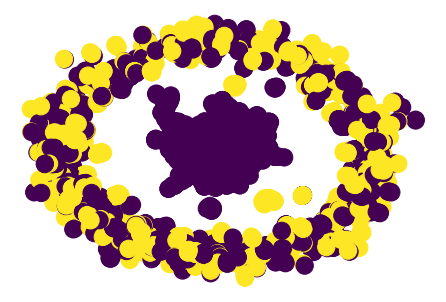

In [20]:

nx.draw(G, pos=nx.drawing.layout.spring_layout(G), 
           with_labels=False, node_color=labels) 


## SNAP Emails

In [9]:
df_snap = pd.read_csv("../data/SNAP_Emails/email-Eu-core.txt", sep=" ", names=["from", "to"])
df_snap

,from,to
0,0,1
1,2,3
2,2,4
3,5,6
4,5,7
...,...,...
25566,420,143
25567,174,859
25568,440,460
25569,52,786


In [55]:
G_SNAP = nx.Graph()
df_snap.apply(lambda x: read_edge(G_SNAP, x[0],x[1]), axis=1)
len(G_SNAP)

1005

In [56]:
save_graph(G_SNAP, "../data/SNAP_Emails/graph2.pdf")


## Random Graph Generator (Test)

# COMMUNITY METHODS

## Degree Counting

In [71]:
# Distribution graph + stats

### Degree Counting in SNAP

<BarContainer object of 348 artists>

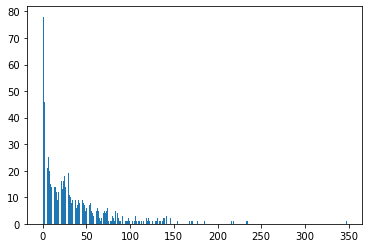

In [77]:
z2 = nx.degree_histogram(G_SNAP)
#plt.hist(z2, bins=range(len(z2)))
#nx.degree_histogram(G_NIPS)
plt.bar(range(len(z2)), z2)


## Spectral Clustering

In [ ]:
# nx adj
# L = D - A
# Lv=λv /eigvec decomp

# eigenvalues indicate the connectivity of a graph
# smallest eigenvalue is always zero.
# number of zeroed eigenvalues indicates number of connected components in the graph.

# Node Counting

## Pipeline w/ SK

# CLUSTING METHODS

# COMMUNITY + CLUSTER